# 0. Correlation Analysis

This notebook performs an $f$-$k$ analysis and filtering, as well as phase velocity dispersion estimation.

# 0. Packages and setup

Import the necessary Python packages and add a few lines to embellish figures.

In [29]:
import obspy
import numpy as np
from pandas import read_csv
from pandas import read_csv
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times"
plt.rcParams.update({'font.size': 50})
plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

# 1. General input

Basic input, including the file to be read and the average spacing between channels.

In [30]:
# Input file.
input_file='/Users/andreas/Codes/BernCorrelations/DATA/bern_5_50Hz_corr_stacked_1s.npy'
# Scale for plotting.
scale=3
# Receiver spacing.
dx=1.9411132335662842

# 2. Data reading and plotting

We first read the correlation data and plot them.

In [52]:
cct=np.load(input_file)

- (Average) distance between channels = 1.9411132335662842 m
- Sampling rate = 200 Hz
- 304 channels (950 - 1306) (number gap due to cutting out chunks)
- 1 hour, n_stack = 12, 002115 - 012115 UTC (01:21:15 - 02:21:15 local time)
- Filtered 5 - 50 Hz

In [53]:
print(cct.shape)
nt=cct.shape[1]
nx=cct.shape[0]-1

(304, 401)


In [54]:
# Normalisation.
for i in range(1,nx): cct[i,:]/=np.max(np.abs(cct[i,:]))

# Tapering in space to avoid wavenumber-domain artefacts.
width=20
for i in range(width): 
    cct[i+1,:]=(np.float(i+1)/np.float(width+1))*cct[i+1,:]
    cct[nx-i,:]=(np.float(i+1)/np.float(width+1))*cct[nx-i,:]

At 0 of 304
At 100 of 304
At 200 of 304
At 300 of 304


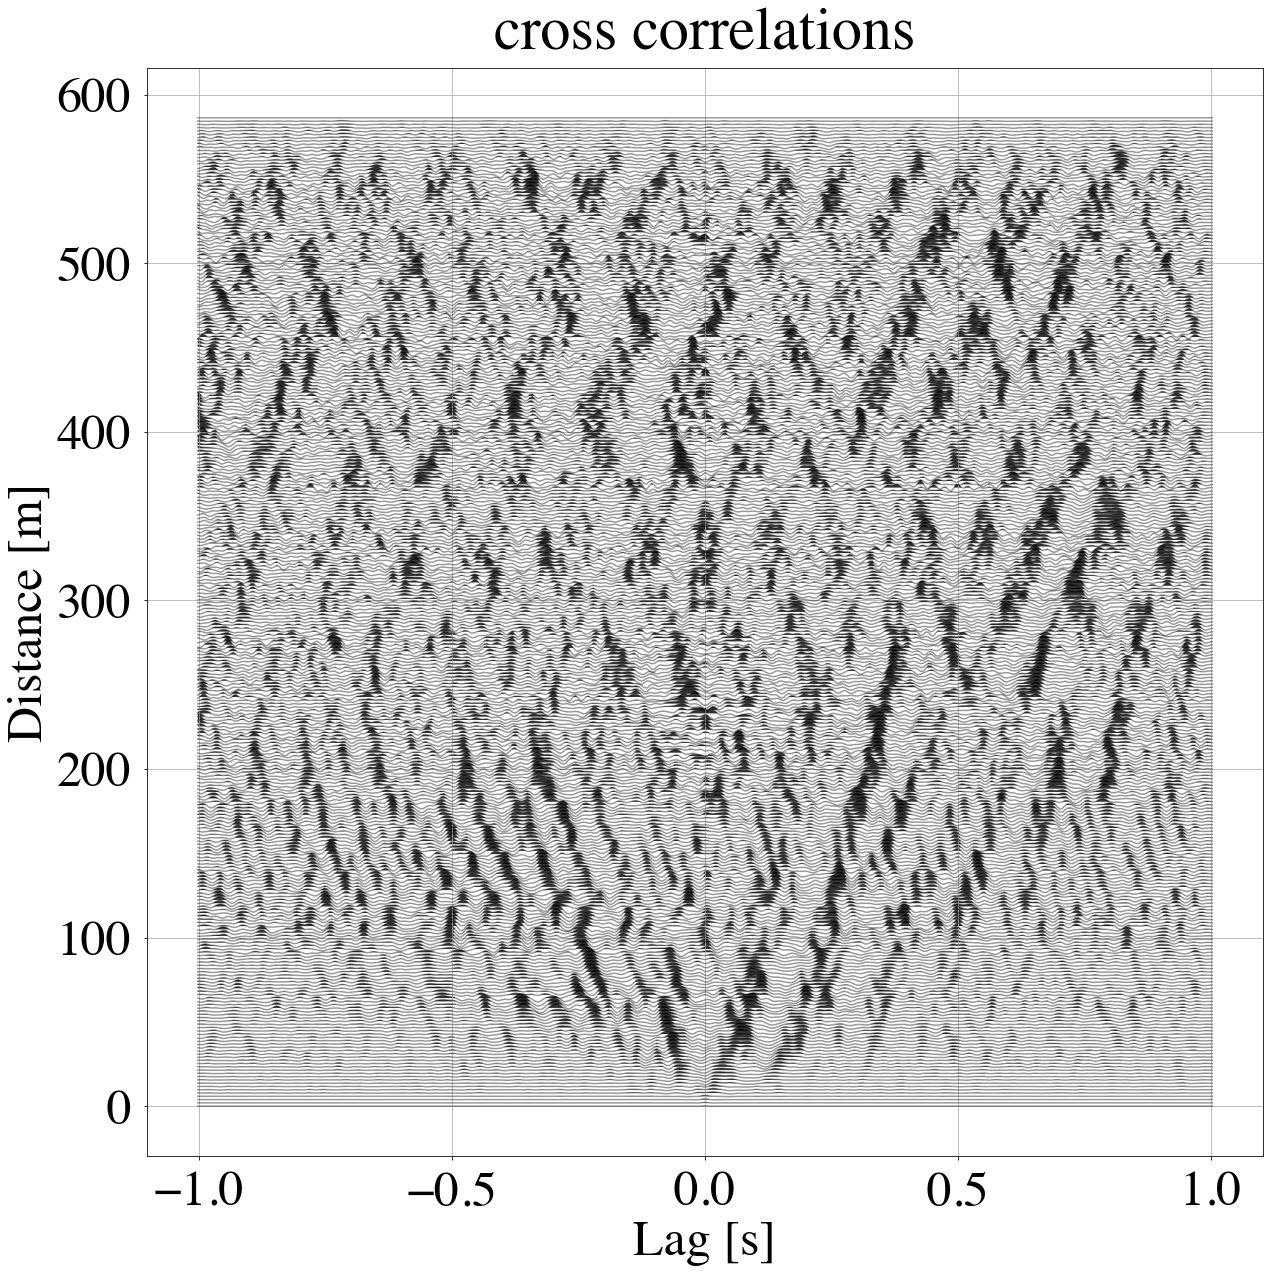

In [55]:
plt.figure(figsize=(20,20))

for i,j in enumerate(cct):
    
    if i % 100 == 0:
        print(f"At {i} of {np.shape(cct)[0]}")
    
    if i == 0:
        t=j
        dt=t[1]-t[0]
    else:
        data = j      
        dist_var = (i-1)*dx

        plt.plot(t,(scale*data)+dist_var,'k-', alpha = 0.4)
        plt.fill_between(t,(scale*data)+dist_var,y2=np.ones(np.shape(t))*dist_var,where=(data+dist_var>=dist_var), interpolate=True,fc='k',alpha=0.8)

plt.xlabel('Lag [s]')
plt.ylabel('Distance [m]')
plt.title('cross correlations',pad=20)
plt.grid()
plt.show()

# 3. Frequency-wavenumber domain

Before any $f$-$k$ filtering and dispersion analysis, we transform the time-domain data into the frequency-wavenumber domain.

## 3.1. Extract causal or acausal parts

We choose either the causal or the acausal part of the correlations for our analysis.

In [56]:
# Pick causal or acausal part.
causal=True

In [57]:
if causal:
    cct_cropped=cct[1:,int((nt-1)/2):nt]
else:
    cct_cropped=cct[1:,int((nt-1)/2)+1:0:-1]
    
t_cropped=np.linspace(0.0,(nt-1)*dt/2.0,int((nt-1)/2)+1)

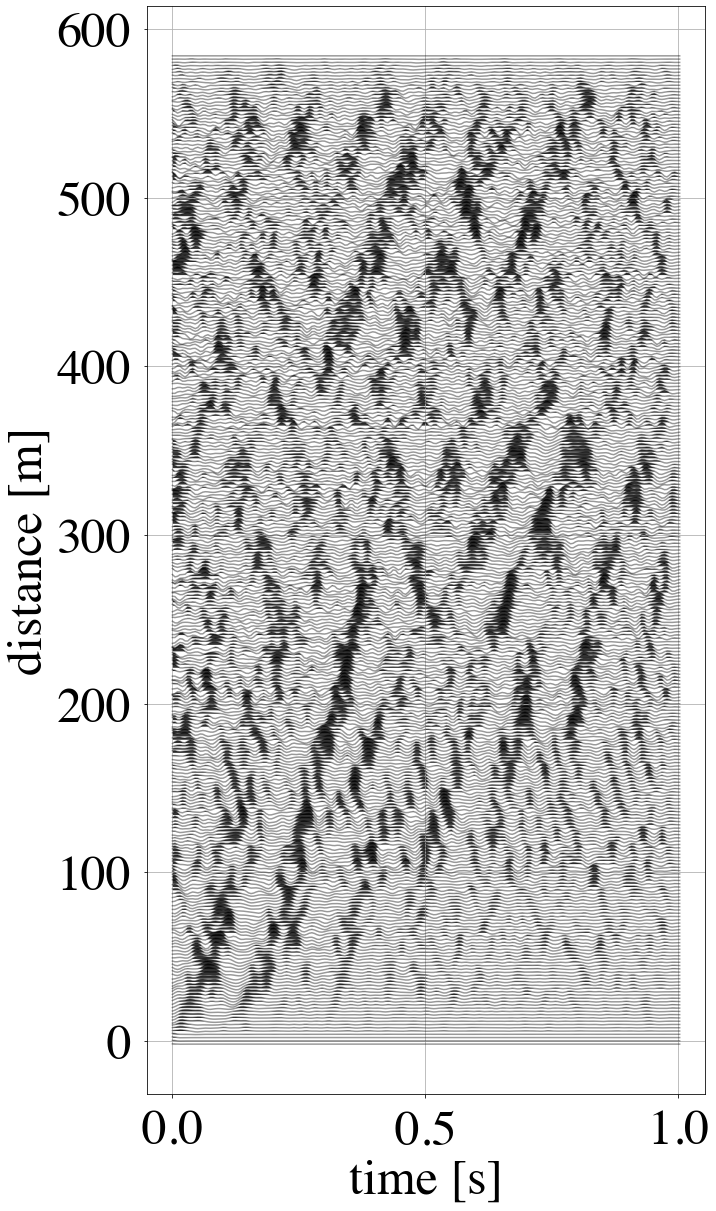

In [58]:
plt.figure(figsize=(10,20))

for i in range(nx):
    
    data=cct_cropped[i,:]      
    dist_var=(i-1)*dx
    
    plt.plot(t_cropped,(scale*data)+dist_var,'k-', alpha = 0.4) 
    plt.fill_between(t_cropped,(scale*data)+dist_var,y2=np.ones(np.shape(t_cropped))*dist_var,where=(data+dist_var>=dist_var), interpolate=True,fc='k',alpha=0.8)

plt.xlabel('time [s]')
plt.ylabel('distance [m]')
plt.grid()
plt.show()

## 3.2. Compute and plot frequency-wavenumber-domain representation

We apply a 2D Fast Fourier Transform and the roll the indices in order to bring it into the physical frequency domain.

In [59]:
# Reduced number of time samples.
nt_cropped=len(t_cropped)
# 2D Fourier transform.
ccf=np.fft.fft2(cct_cropped)
# Roll in order to plot in physical f-k domain.
ccfr=np.roll(np.roll(ccf,int((nt_cropped-1)/2),axis=1),int((nx-1)/2),axis=0)
# Make frequency and wavenumber axes.
f=np.linspace(-0.5/dt,0.5/dt,nt_cropped)
k=np.linspace(-np.pi/dx,np.pi/dx,nx)
ff,kk=np.meshgrid(f,k)

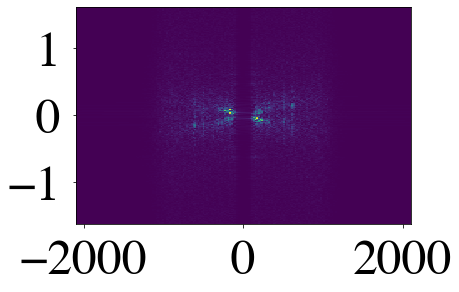

In [51]:
plt.pcolor(ff,kk,np.abs(ccfr))

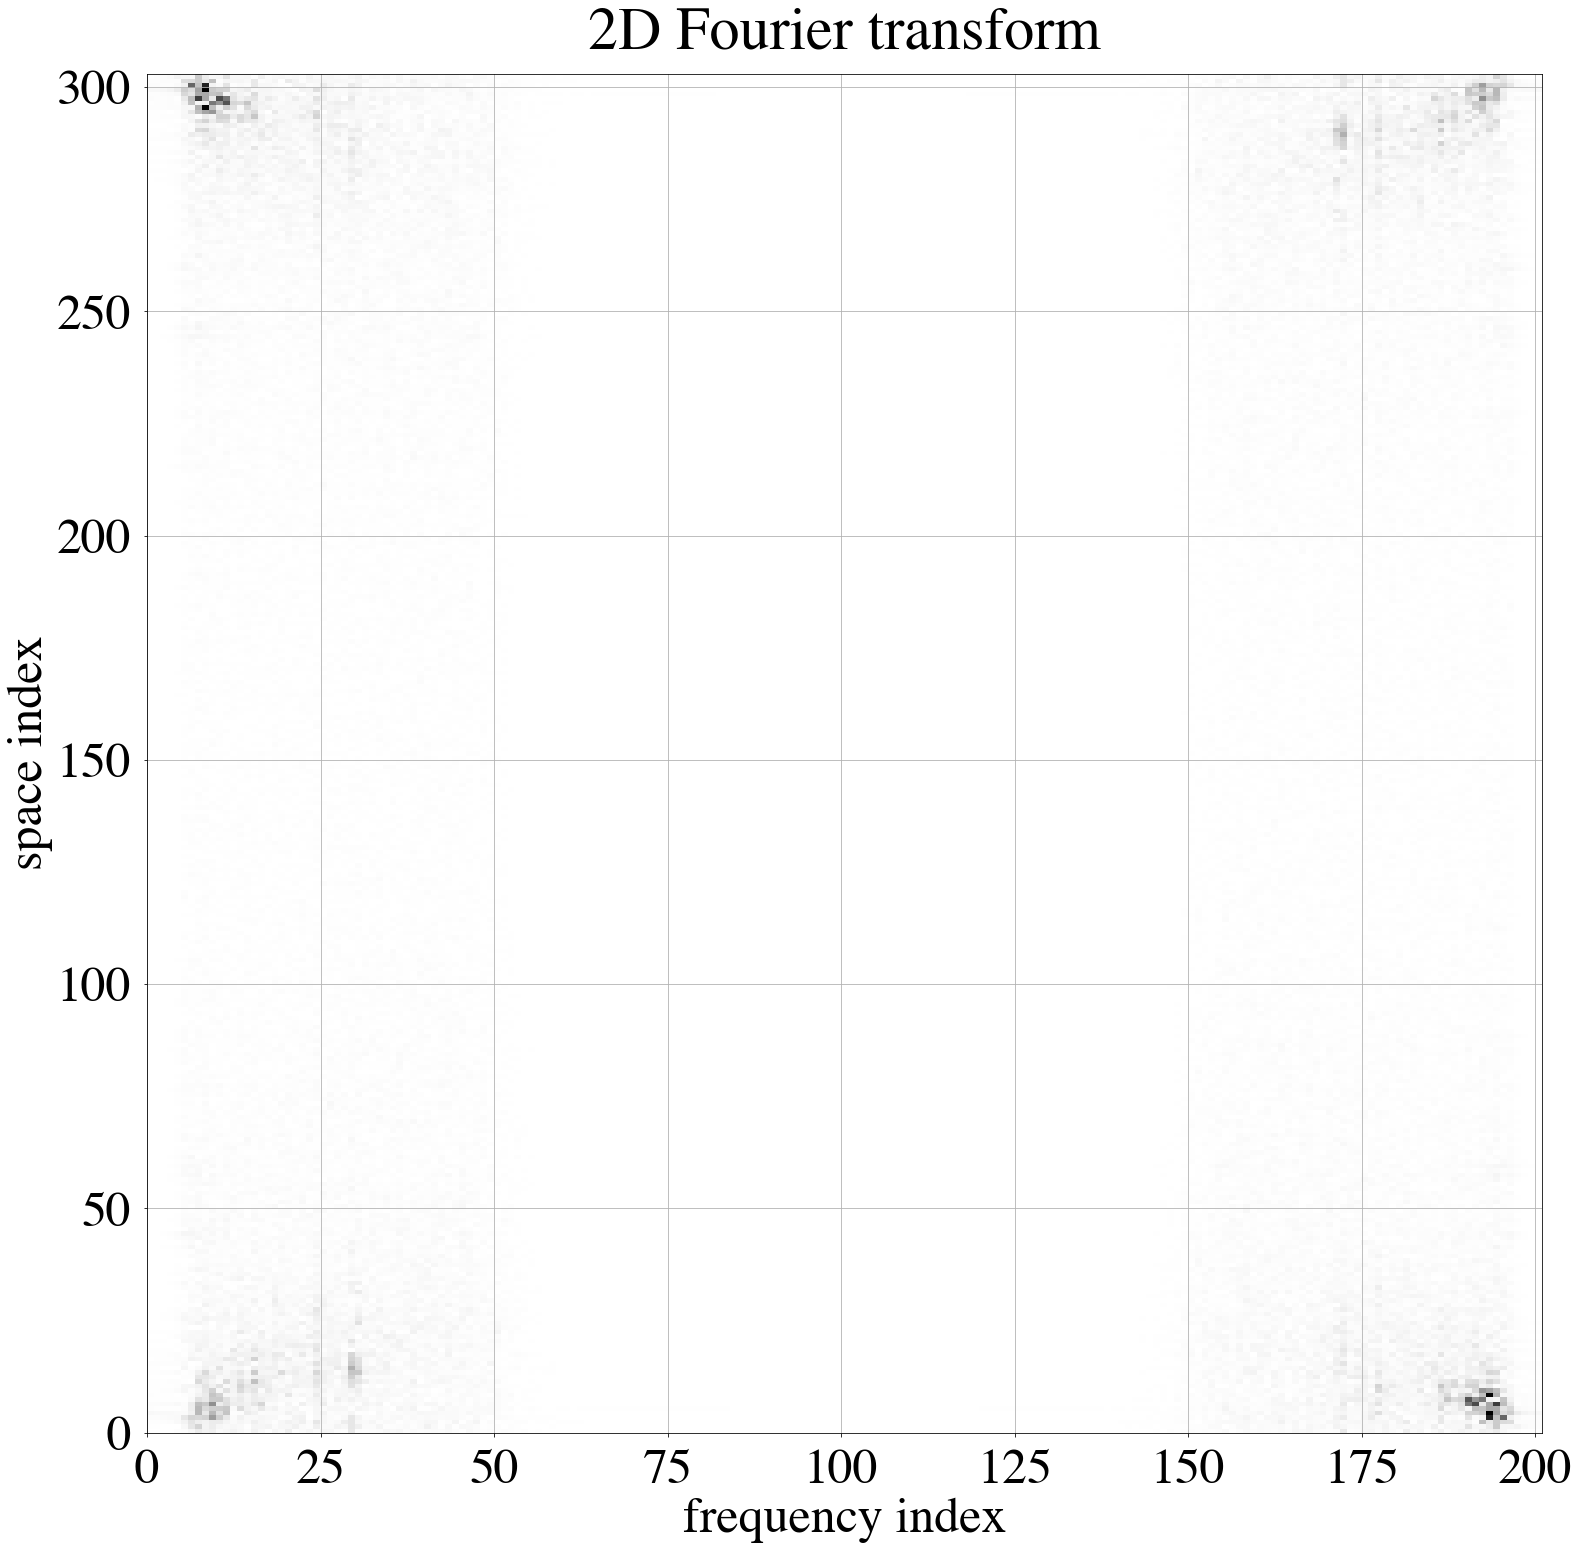

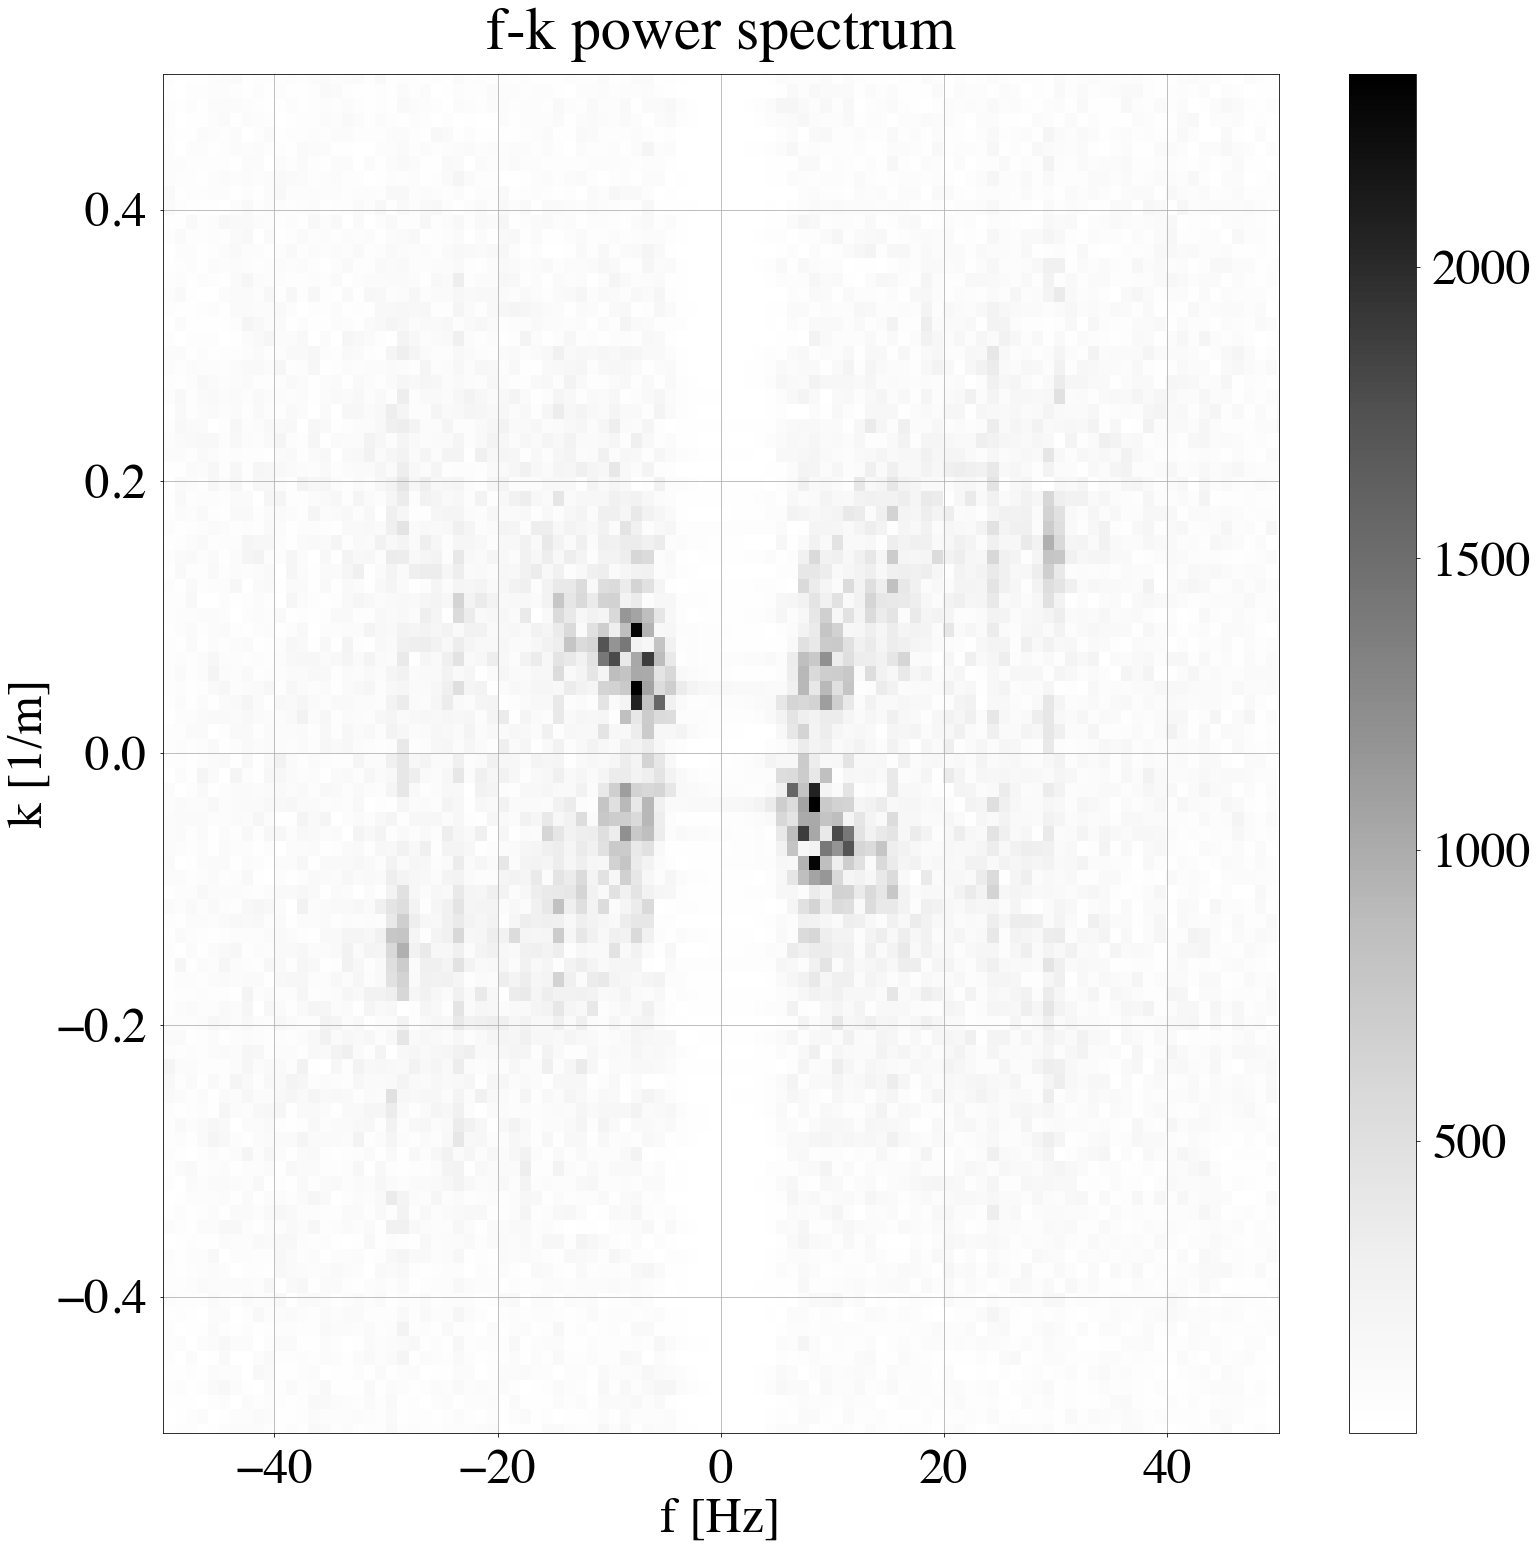

In [60]:
# Plot discrete 2D Fourier transform
plt.subplots(1, figsize=(25,25))
plt.pcolor(np.abs(ccf),cmap='Greys')
plt.xlabel('frequency index')
plt.ylabel('space index')
plt.title('2D Fourier transform',pad=25)
plt.grid()
plt.show()

# Plot f-k domain amplitude spectrum.
plt.subplots(1, figsize=(25,25))
plt.pcolor(ff,kk,np.abs(ccfr),cmap='Greys')
plt.xlim(-50.0,50.0)
plt.ylim(-0.5,0.5)
plt.xlabel('f [Hz]')
plt.ylabel('k [1/m]')
plt.title('f-k power spectrum',pad=25)
plt.colorbar()
plt.grid()
plt.show()

## 3.3. Compute $c$-$k$ representation

In some cases, a velocity-frequency plot can be more useful. For this, we transform the $f$-$k$ plot by looping through velocities and frequencies, computing $k=\omega/c$ and then getting the appropriate power-spectral value.

# 4. $f$-$k$ filtering

For $f$-$k$ filtering we define a mask that cuts out part of the $f$-$k$ spectrum.

## 4.1. Input

Set parameters that define the frequency-wavenumber mask.

In [61]:
# Minimum and maximum absolute phase velocities [m/s].
c_min=300.0
c_max=1200.0
# Minimum and maximum frequencies [Hz].
freqmin=5.0
freqmax=30.0

## 4.2. $f$-$k$ mask

Build the $f$-$k$ mask for both the forward- and backward-propagating (reflected) part of the correlation wavefield.

In [62]:
# Mask for forward-propagating wavefield.
mask_fwd=np.ones(np.shape(ccfr),dtype='complex64')
# Mask for backward-propagating (reflected) wavefield.
mask_rev=np.ones(np.shape(ccfr),dtype='complex64')

# Apply the mask.
for i in range(nx):
    for j in range(nt_cropped):
        
        # Compute phase velocity.
        if np.abs(k[i]):
            c=2.0*np.pi*f[j]/k[i]
        else:
            c=1.0e9
            
        # Maximum and minimum absolute phase velocities.
        if (np.abs(c)>c_max) or (np.abs(c)<c_min):
            mask_fwd[i,j]=0.0
            mask_rev[i,j]=0.0
        # Forward or backward propagation.
        if c>0.0: mask_fwd[i,j]=0.0
        if c<0.0: mask_rev[i,j]=0.0
        # Bandpass filter.
        if np.abs(f[j])>freqmax: 
            mask_fwd[i,j]=0.0
            mask_rev[i,j]=0.0
        if np.abs(f[j])<freqmin: 
            mask_fwd[i,j]=0.0
            mask_rev[i,j]=0.0
            
            
# Smooth the mask.
dummy_fwd=mask_fwd.copy()
mask_fwd_smooth=mask_fwd.copy()
dummy_rev=mask_rev.copy()
mask_rev_smooth=mask_rev.copy()

for l in range(4):
    for i in np.arange(1,nx-1):
        for j in np.arange(1,nt_cropped-1):
            mask_rev_smooth[i,j]=(dummy_rev[i,j]+dummy_rev[i-1,j]+dummy_rev[i+1,j]+dummy_rev[i,j-1]+dummy_rev[i,j+1])/5.0
            mask_fwd_smooth[i,j]=(dummy_fwd[i,j]+dummy_fwd[i-1,j]+dummy_fwd[i+1,j]+dummy_fwd[i,j-1]+dummy_fwd[i,j+1])/5.0
    dummy_rev=mask_rev_smooth
    dummy_fwd=mask_fwd_smooth

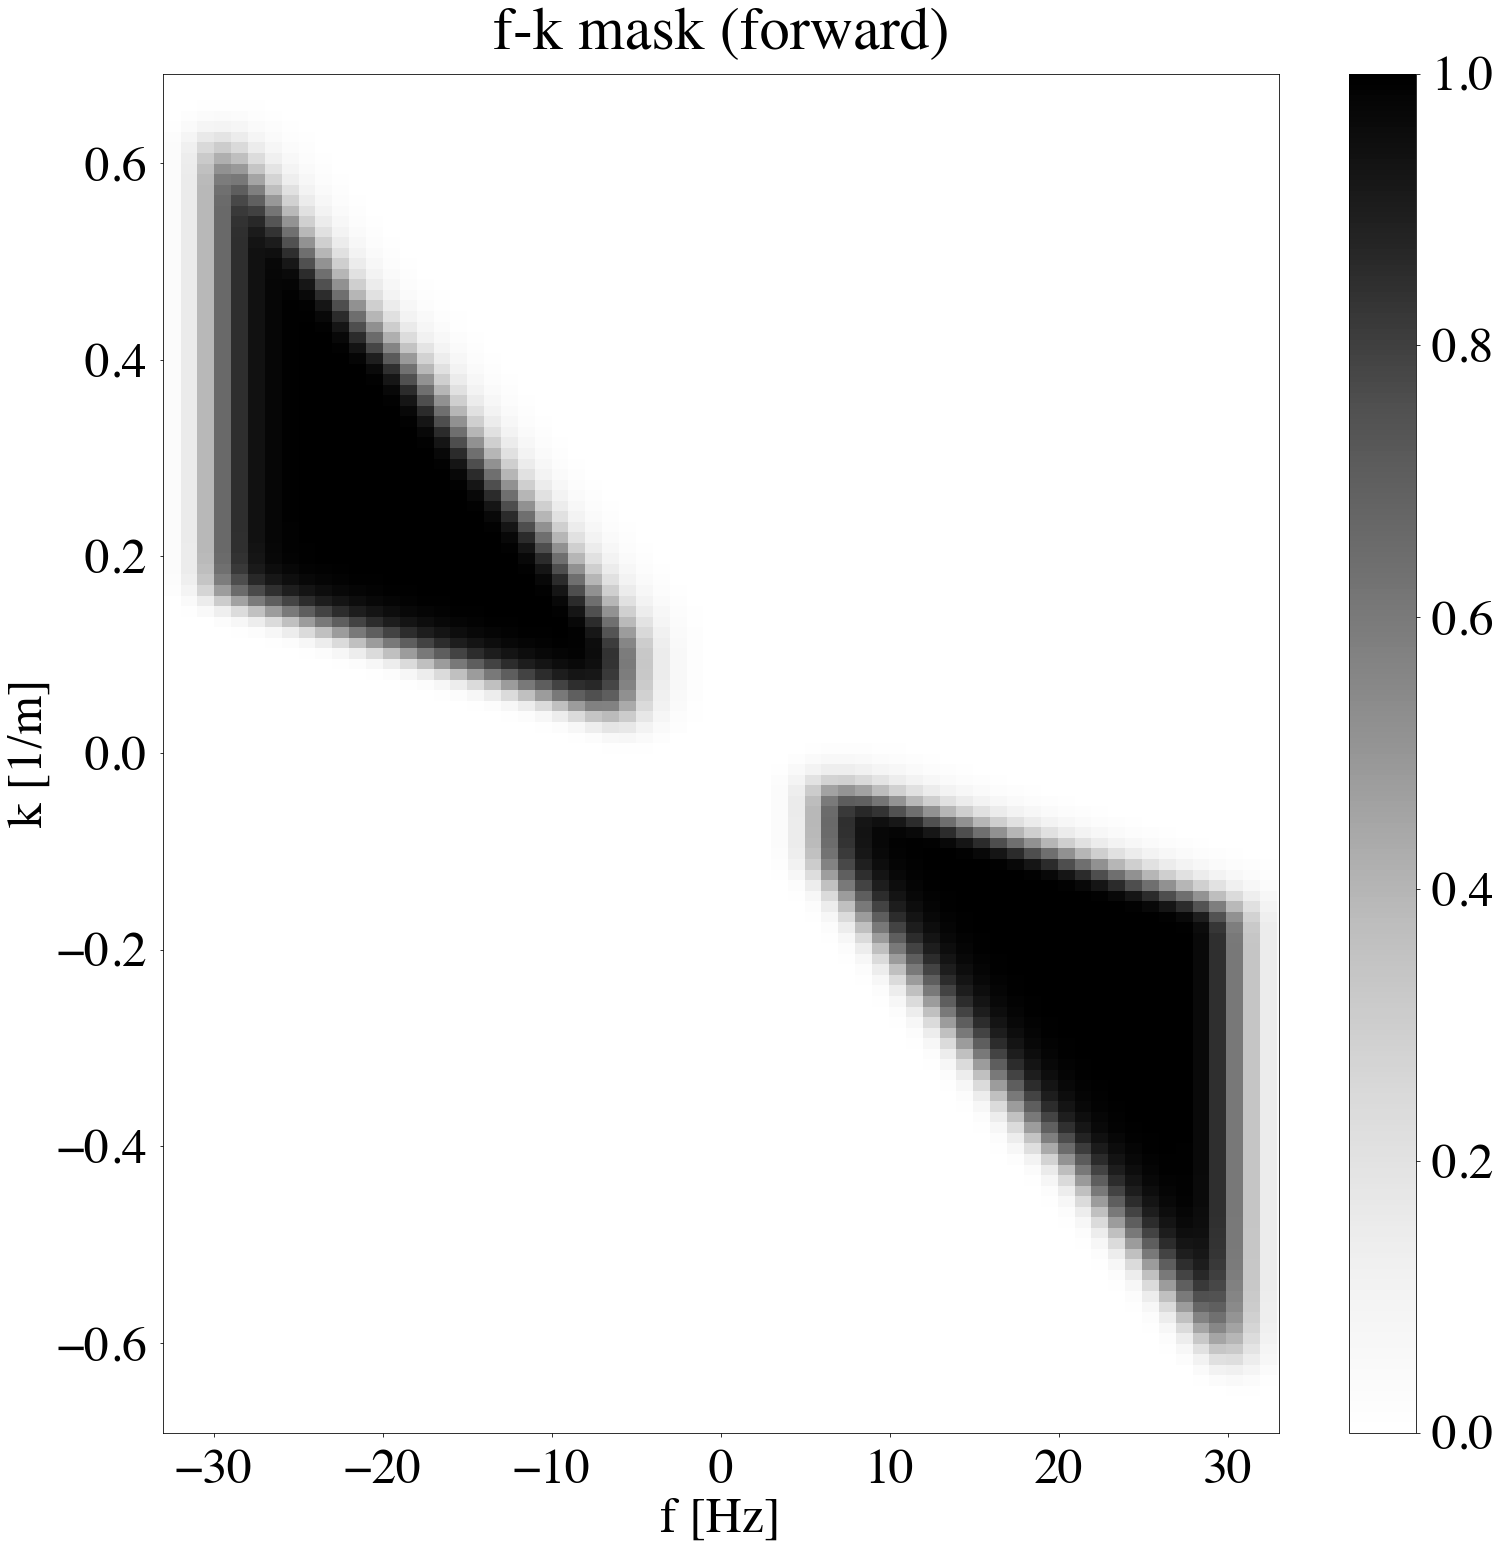

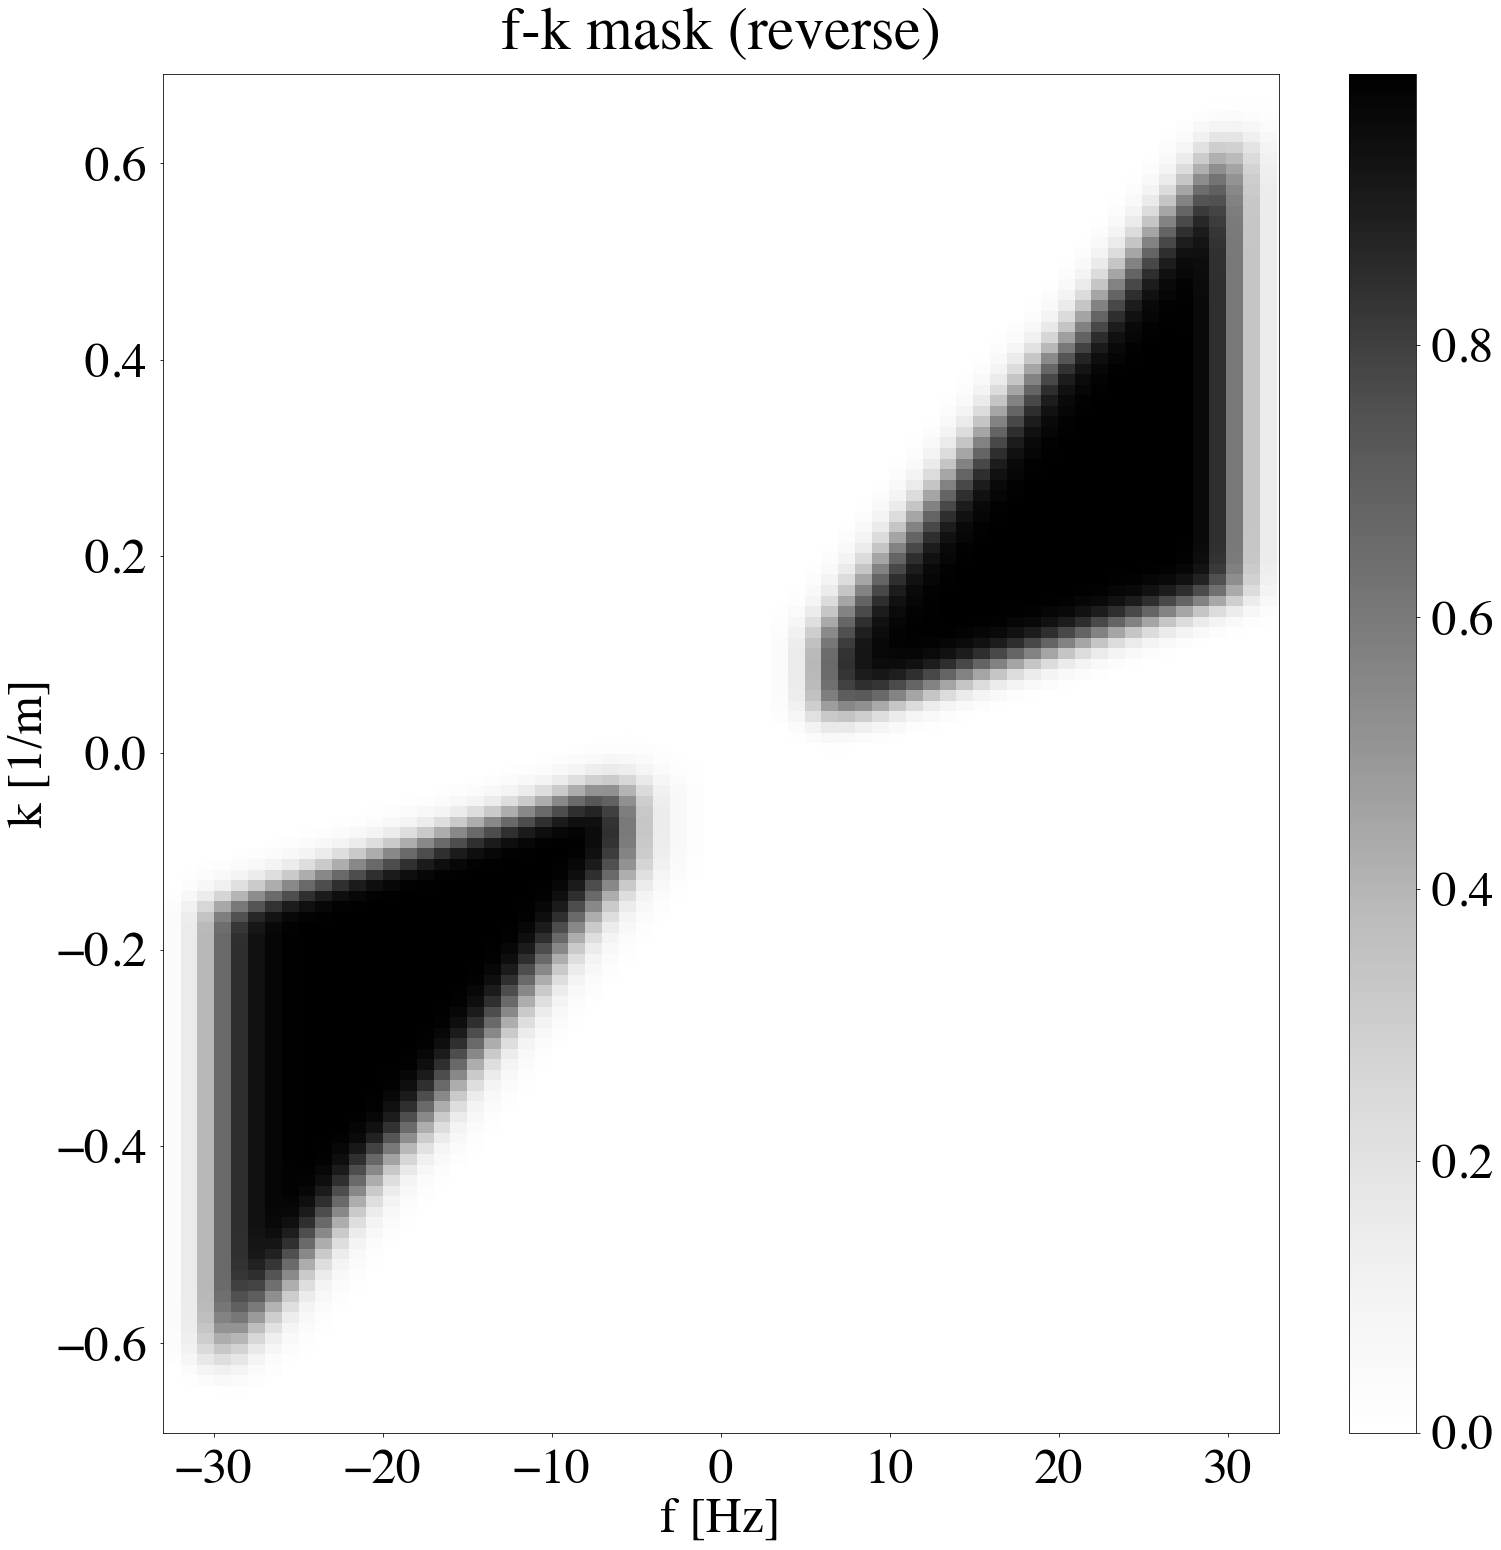

In [63]:
# Plot f-k domain masks.

plt.subplots(1, figsize=(25,25))
plt.pcolor(ff,kk,np.abs(mask_fwd_smooth),cmap='Greys')
plt.xlim(-1.1*freqmax,1.1*freqmax)
plt.ylim(-2.2*np.pi*freqmax/c_min,2.2*np.pi*freqmax/c_min)
plt.xlabel('f [Hz]')
plt.ylabel('k [1/m]')
plt.title('f-k mask (forward)',pad=25)
plt.colorbar()
plt.show()

plt.subplots(1, figsize=(25,25))
plt.pcolor(ff,kk,np.abs(mask_rev_smooth),cmap='Greys')
plt.xlim(-1.1*freqmax,1.1*freqmax)
plt.ylim(-2.2*np.pi*freqmax/c_min,2.2*np.pi*freqmax/c_min)
plt.xlabel('f [Hz]')
plt.ylabel('k [1/m]')
plt.title('f-k mask (reverse)',pad=25)
plt.colorbar()
plt.show()

In [64]:
# Apply the f-k domain filter.
ccfr_fwd_filtered=ccfr*mask_fwd_smooth
ccfr_rev_filtered=ccfr*mask_rev_smooth

## 4.3. Return to the time domain

After application of the mask (filter) we roll the arrays back and then apply the 2D inverse transform.

In [65]:
# Roll back.
ccf_fwd_filtered=np.roll(np.roll(ccfr_fwd_filtered,-int((nt_cropped-1)/2),axis=1),-int((nx-1)/2),axis=0)
ccf_rev_filtered=np.roll(np.roll(ccfr_rev_filtered,-int((nt_cropped-1)/2),axis=1),-int((nx-1)/2),axis=0)

# Plot to check.
#plt.subplots(1, figsize=(25,25))
#plt.pcolor(np.abs(ccf_fwd_filtered),cmap='Greys')
#plt.xlabel('frequency index')
#plt.ylabel('space index')
#plt.title('2D Fourier transform, filtered',pad=25)
#plt.show()

# Inverse 2D Fourier transform.
cct_fwd_filtered=np.real(np.fft.ifft2(ccf_fwd_filtered))
cct_rev_filtered=np.real(np.fft.ifft2(ccf_rev_filtered))

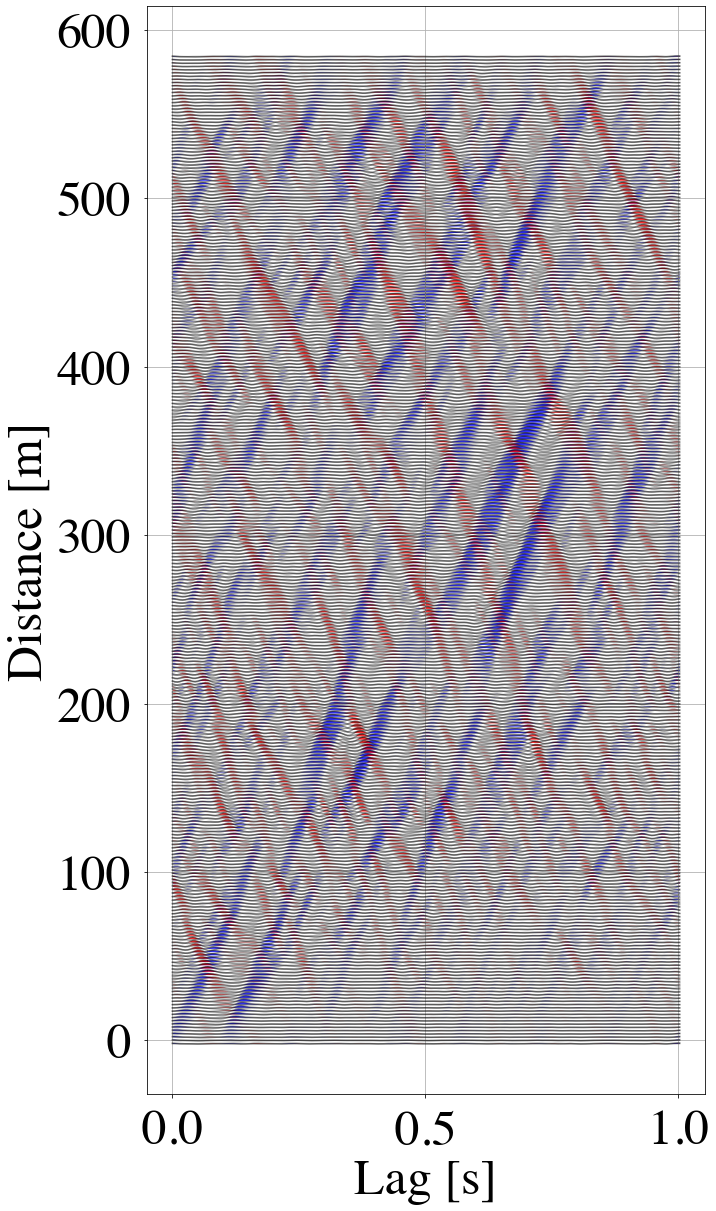

In [66]:
# Plotting options.
plot_forward=True
plot_reverse=True

# Plot filtered version.
plt.figure(figsize=(10,20))

for i in range(nx):
    
    dist_var=(i-1)*dx
    
    if plot_forward:
        data_fwd=cct_fwd_filtered[i,:]
        #data_fwd/=np.max(np.abs(cct_cropped[i,:]))  
        plt.plot(t_cropped,(scale*data_fwd)+dist_var,'k-', alpha = 0.4) 
        plt.fill_between(t_cropped,(scale*data_fwd)+dist_var,y2=np.ones(np.shape(t_cropped))*dist_var,where=(data_fwd+dist_var>=dist_var), interpolate=True,fc='b',alpha=0.8)
        
    if plot_reverse:
        data_rev=cct_rev_filtered[i,:]
        #data_rev/=np.max(np.abs(cct_cropped[i,:]))   
        plt.plot(t_cropped,(scale*data_rev)+dist_var,'k-', alpha = 0.4) 
        plt.fill_between(t_cropped,(scale*data_rev)+dist_var,y2=np.ones(np.shape(t_cropped))*dist_var,where=(data_rev+dist_var>=dist_var), interpolate=True,fc='r',alpha=0.8)

plt.xlabel("Lag [s]")
plt.ylabel("Distance [m]")
plt.grid()
plt.show()

In [19]:
# Store forward and backward correlation fields.
np.save('./IO/cct_raw.npy',cct_cropped)
np.save('./IO/cct_forward.npy',cct_fwd_filtered)
np.save('./IO/cct_reverse.npy',cct_rev_filtered)

# 5. Phase velocity dispersion measurements

We estimate phase velocity dispersion by picking the maximum of the $k$-dependent spectrum.

## 5.1. Input

Choose the frequency band for the dispersion estimation, and the degree of spectral smoothing.

# 6. Prepare input for migration

# 6.1. Restrict number of channels and time samples

In [20]:
# maximum offset [m]
x_max=200
# maximum time [s]
t_max=0.5

# Compute samples indices.
nx_new=int(np.round(x_max/dx))
nt_new=int(np.round(t_max/dt))

# Crop f-k-filtered recordings.
cct_fwd_filtered_new=cct_fwd_filtered[0:nx_new,0:nt_new]
cct_rev_filtered_new=cct_rev_filtered[0:nx_new,0:nt_new]
t_new=np.linspace(0,nt_new*dt,nt_new)

In [21]:
nx_new

103

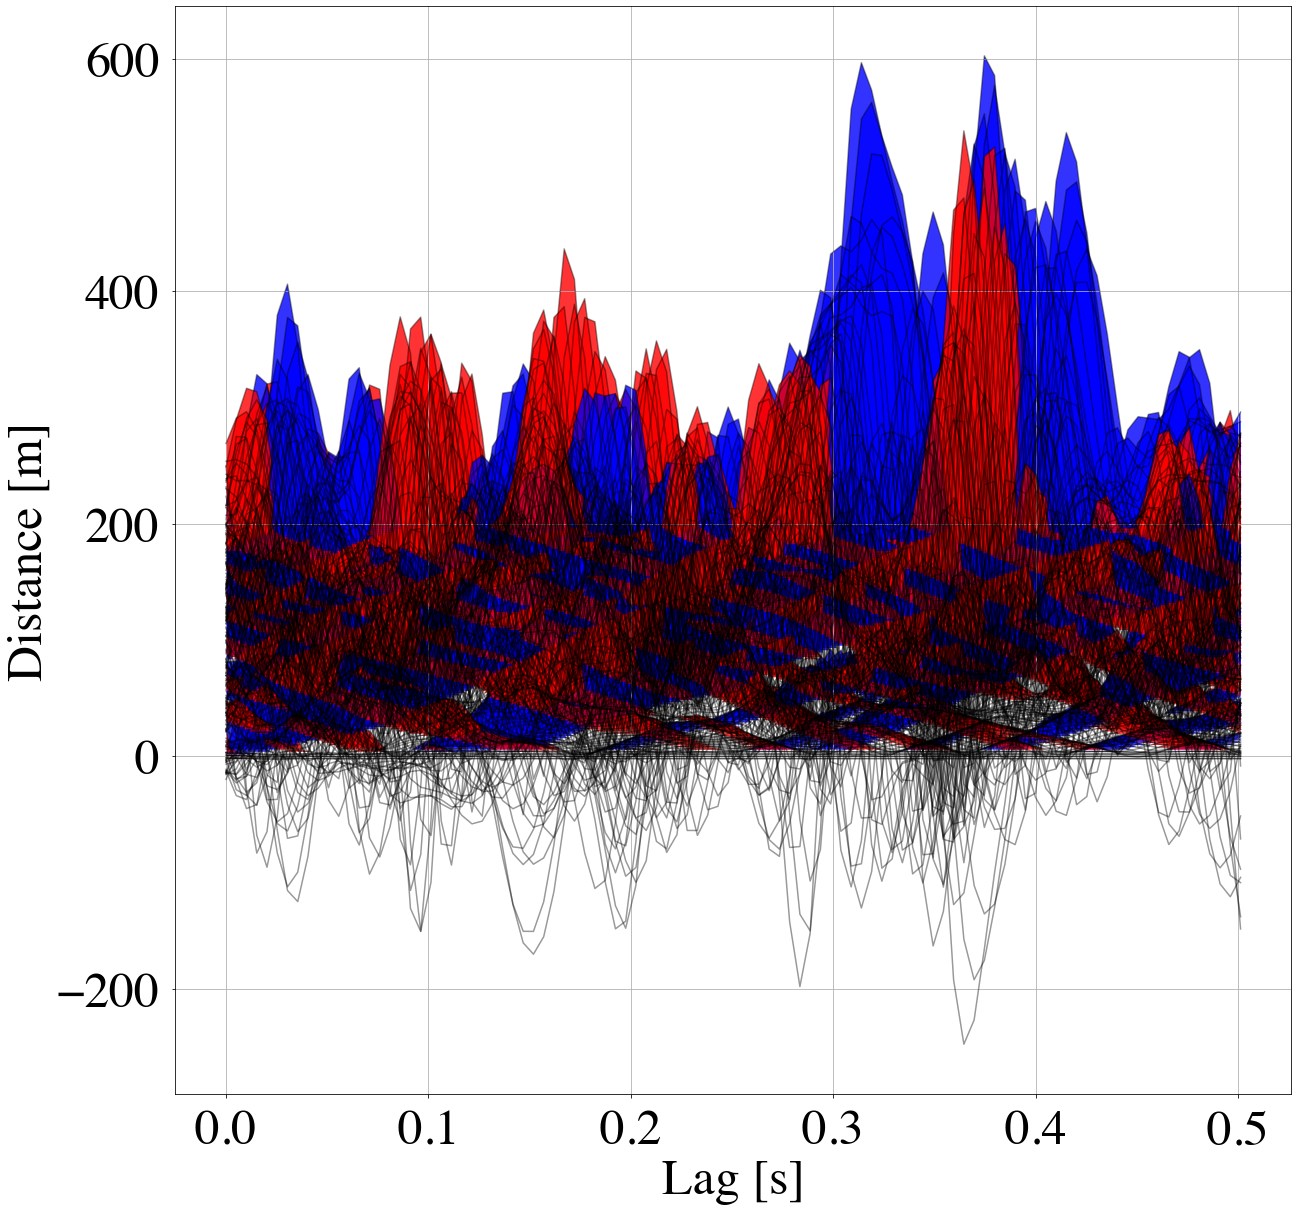

In [22]:
# Plotting options.
plot_forward=True
plot_reverse=True

# Plot filtered version.
plt.figure(figsize=(20,20))

for i in range(nx_new):
    
    dist_var=(i-1)*dx
    
    if plot_forward:
        data_fwd=cct_fwd_filtered_new[i,:]
        data_fwd/=np.max(np.abs(cct_cropped[i,0:nt_new]))  
        plt.plot(t_new,(scale*data_fwd)+dist_var,'k-', alpha = 0.4) 
        plt.fill_between(t_new,(scale*data_fwd)+dist_var,y2=np.ones(np.shape(t_new))*dist_var,where=(data_fwd+dist_var>=dist_var), interpolate=True,fc='b',alpha=0.8)
        
    if plot_reverse:
        data_rev=cct_rev_filtered_new[i,:]
        data_rev/=np.max(np.abs(cct_cropped[i,:]))   
        plt.plot(t_new,(scale*data_rev)+dist_var,'k-', alpha = 0.4) 
        plt.fill_between(t_new,(scale*data_rev)+dist_var,y2=np.ones(np.shape(t_new))*dist_var,where=(data_rev+dist_var>=dist_var), interpolate=True,fc='r',alpha=0.8)

plt.xlabel("Lag [s]")
plt.ylabel("Distance [m]")
plt.grid()
plt.show()

In [23]:
np.save('./IO/cct_reverse_cropped.npy',cct_rev_filtered_new)

## 6.2. Compute and store source and receiver positions in Cartesian coordinates

### 6.2.1. Input

In [24]:
# Reference coordinates for coordinate origin [°].
lat_ref=46.9532
lon_ref=7.4290

# Number of starting channel (currently also the virtual source channel).
channel_start=950 

# Read in the GPS locations from file
section_location_all = read_csv('/Users/andreas/Codes/BernCorrelations/DATA/section_location_all.csv')

### 6.2.2. Read coordinates of all channels

In [25]:
# Put channel locations into a dictionary for easier access. Contains channel number; latitude; longitude
sec_loc_dict = dict()
for i in section_location_all.iterrows(): sec_loc_dict.update({f"{int(i[1][0])}":[i[1][1],i[1][2]]})

# Fill arrays of latitudes and longitudes of channels.
lats=np.zeros(nx_new)
lons=np.zeros(nx_new)

i=0
k=0
while k < nx_new:
    if f'{channel_start+i}' in sec_loc_dict.keys():
        lats[k]=sec_loc_dict[f'{channel_start+i}'][0]
        lons[k]=sec_loc_dict[f'{channel_start+i}'][1]
        k+=1
    i+=1

In [26]:
lons[0]

7.4297100000000142

### 6.2.3. Project position vectors onto tangential unit vectors at the reference point

In order to be able to work in 2-D Cartesian coordinates, we need to project the position vector of each channel at the surface of the Earth onto the unit vectors in $\theta$- and $\phi$-direction. The $phi$-direction is then defined as $x$ and the $\theta$-direction as $y$. This works because the domain is very small compared to the radius of the Earth.

In [27]:
# Radius of the Earth [m].
r=6371.0e3

# Convert to radians.
phi=np.pi*lons/180.0
theta=np.pi*lats/180.0
phi_ref=np.pi*lon_ref/180.0
theta_ref=np.pi*lat_ref/180.0

# Unit vector in phi-direction at reference point.
x_phi=np.cos(phi_ref)
y_phi=-np.sin(phi_ref)
z_phi=0.0

# Unit vector in theta-direction at reference point.
x_theta=-np.sin(phi_ref)*np.sin(theta_ref)
y_theta=-np.cos(phi_ref)*np.sin(theta_ref)
z_theta=np.cos(theta_ref)

# Vector of each point.
x=r*np.sin(phi)*np.cos(theta)
y=r*np.cos(phi)*np.cos(theta)
z=r*np.sin(theta)

# Projections of the position vector onto the unit vectors.
xx=x*x_phi+y*y_phi+z*z_phi
yy=x*x_theta+y*y_theta+z*z_theta

### 6.2.4. Plot and save channel locations in Cartesian coordinates.

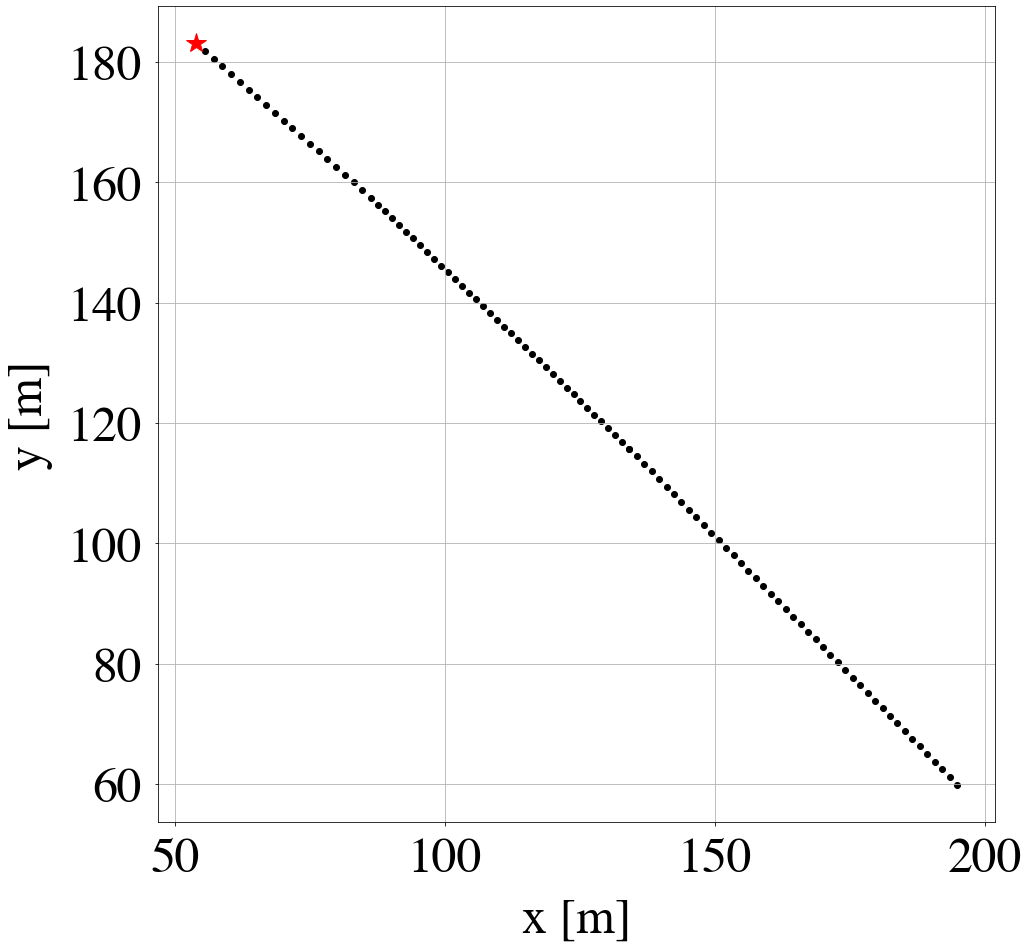

In [28]:
# Plot.
plt.subplots(1, figsize=(15,15))
plt.scatter(xx,yy,c='k')
plt.plot(xx[0],yy[0],'r*',MarkerSize=20)
plt.xlabel('x [m]',labelpad=15)
plt.ylabel('y [m]',labelpad=15)
plt.grid()
plt.show()

# Save.
np.save('./IO/time.npy',t_new)
np.save('./IO/channels_x.npy',xx)
np.save('./IO/channels_y.npy',yy)